# 技術側の分析


<a id=top></a>


<a href="#data">データインポート</a>


---


<a id=init></a>

## **1. モジュールインポート・初期条件設定**


In [1]:
import pandas as pd
import numpy as np
import sys

sys.path.append("../../src")
from ecomplexity import ecomplexity
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import io

import matplotlib.ticker as ptick
import networkx as nx
import networkx.algorithms.bipartite as bip

plt.rcParams["font.family"] = "Meiryo"
plt.rcParams["font.size"] = 20

# 小数点以下 桁数 6
pd.options.display.float_format = "{:.3f}".format

In [2]:
import initial_condition
from process import weight
from visualize import rank as vr

In [3]:
global data_dir, ex_dir, output_dir
data_dir = "../../data/processed/internal/technology/"
ex_dir = "../../data/processed/external/schmoch/"
output_dir = "../../output/figures/"

In [4]:
# 初期条件
ar = initial_condition.AR
year_style = initial_condition.YEAR_STYLE

year_start = initial_condition.YEAR_START
year_end = initial_condition.YEAR_END
year_range = initial_condition.YEAR_RANGE

extract_population = initial_condition.EXTRACT_POPULATION
top_p_or_num = initial_condition.TOP_P_OR_NUM
region_corporation = initial_condition.REGION_CORPORATION
applicant_weight = initial_condition.APPLICANT_WEIGHT

classification = initial_condition.CLASSIFICATION
class_weight = initial_condition.CLASS_WEIGHT

color_list = initial_condition.COLOR_LIST

input_condition = f'{ar}_{year_style}_{extract_population}_{top_p_or_num[0]}_{top_p_or_num[1]}_{region_corporation}_{applicant_weight}_{classification}_{class_weight}'
fig_name_base = f'{ar}_{year_style}_{extract_population}_{top_p_or_num[0]}_{top_p_or_num[1]}_{region_corporation}_{applicant_weight}_{classification}_{class_weight}.png'


In [5]:
# 条件確認
input_condition

'app_nendo_all_p_100_right_person_addr_fraction_schmoch35_fraction'

In [6]:
period_order_dict = {
    f"{period_start}-{period_start+year_range-1}": i
    for i, period_start in enumerate(range(year_start, year_end + 1, year_range))
}

period_order_dict[f"{year_start}-{year_end}"] = len(period_order_dict)
period_order_dict

{'1981-1990': 0, '1991-2000': 1, '2001-2010': 2, '1981-2010': 3}

<a href=#top>TOP に戻る</a>

---


<a id="data"></a>

## **2. データインポート**


In [7]:
df = pd.read_csv(
    f"{data_dir}{input_condition}.csv", sep=","
)

schmoch_df = pd.read_csv(
    f"{ex_dir}35.csv", encoding="utf-8", sep=",", usecols=["Field_number", "Field_en"]
).drop_duplicates()

# df = (
#     pd.merge(
#         df, schmoch_df, left_on=classification, right_on="Field_number", how="left"
#     )
#     .drop(columns=["Field_number", classification])

#     .rename(columns={"Field_en": classification})

# )
df = df.sort_values(
    f"{ar}_{year_style}_period", key=lambda col: col.map(period_order_dict)
)

df

app_nendo_period    reg_num  right_person_addr  ubiquity    tci   ki_1  \
0          1981-1990  56290.500                 47        15  0.931 12.400   
104        1981-1990  29833.500                 44         7  3.711 10.143   
120        1981-1990  19838.000                 46        19 -0.229 11.842   
64         1981-1990  27405.000                 42         7 -1.766 14.000   
28         1981-1990  33453.000                 43        17  1.722 12.706   
..               ...        ...                ...       ...    ...    ...   
41         1981-2010   8401.500                 46        29 -0.575 13.690   
37         1981-2010 174278.500                 47        14  2.578 14.143   
113        1981-2010 119763.667                 47        37 -1.379 12.892   
101        1981-2010 111932.000                 47        23  0.870 12.957   
69         1981-2010  30706.000                 47        39 -0.742 12.718   

      ki_2   ki_3   ki_4   ki_5  ...  ki_12  ki_13  ki_14  ki_15  ki_16  \
0   18.781 12.288 19.402 12.242  ... 19.665 12.224 19.666 12.224 19.666   
104 17.027 11.909 18.953 12.164  ... 19.659 12.224 19.664 12.224 19.666   
120 20.556 11.993 19.938 12.158  ... 19.668 12.223 19.667 12.223 19.667   
64  18.537 12.537 19.716 12.279  ... 19.670 12.224 19.668 12.223 19.667   
28  18.219 12.398 19.153 12.269  ... 19.662 12.224 19.665 12.224 19.666   
..     ...    ...    ...    ...  ...    ...    ...    ...    ...    ...   
41  22.811 13.507 22.231 13.468  ... 22.093 13.458 22.093 13.458 22.093   
37  19.835 13.481 21.561 13.454  ... 22.091 13.458 22.093 13.458 22.093   
113 23.470 13.422 22.358 13.455  ... 22.094 13.458 22.093 13.458 22.093   
101 21.517 13.360 21.902 13.441  ... 22.092 13.458 22.093 13.458 22.093   
69  23.130 13.398 22.258 13.451  ... 22.093 13.458 22.093 13.458 22.093   

     ki_17  ki_18  ki_19  ki_20                                schmoch35  
0   12.223 19.667 12.223 19.667  Electrical machinery, apparatus, energy  
104 12.223 19.666 12.223 19.667                 Engines, pumps, turbines  
120 12.223 19.667 12.223 19.667                      Mechanical elements  
64  12.223 19.667 12.223 19.667       Macromolecular chemistry, polymers  
28  12.224 19.667 12.223 19.667                           Semiconductors  
..     ...    ...    ...    ...                                      ...  
41  13.458 22.093 13.458 22.093         Analysis of biological materials  
37  13.458 22.093 13.458 22.093                              Measurement  
113 13.458 22.093 13.458 22.093                   Other special machines  
101 13.458 22.093 13.458 22.093                            Machine tools  
69  13.458 22.093 13.458 22.093                           Food chemistry  

[140 rows x 26 columns]

In [8]:
# import matplotlib.pyplot as plt
# import pandas as pd
# import seaborn as sns
# import squarify

# sns.set_style("darkgrid")
# df_2col = df[df[f"{ar}_{year_style}_period"] == f"{year_start}-{year_end}"][
#     [classification, "reg_num"]
# ].sort_values("reg_num", ascending=False)
# # df_raw = pd.read_csv("https://github.com/selva86/datasets/raw/master/import squarify.csv")

# # df_raw = pd.read_csv("https://github.com/selva86/datasets/raw/master/mpg_ggplot2.csv")
# # display(df_raw)
# # display(df_raw.groupby('class').size().reset_index(name='counts'))
# labels = df_2col.apply(lambda x: str(x[0]) + "\n (" + str(round(x[1], 1)) + ")", axis=1)
# sizes = df_2col["reg_num"].values.tolist()
# colors = [plt.cm.Spectral(i / float(len(labels))) for i in range(len(labels))]
# # colors = color_list
# # display(sizes)
# plt.figure(figsize=(40, 30), dpi=120)
# squarify.plot(sizes=sizes, label=labels, color=colors, alpha=0.8)

# plt.title("Treemap of Vechile Class")
# plt.axis("off")
# plt.show()

In [9]:
df_2col

NameError: name 'df_2col' is not defined

c:\Users\rin\anaconda3\envs\economic_complexity\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


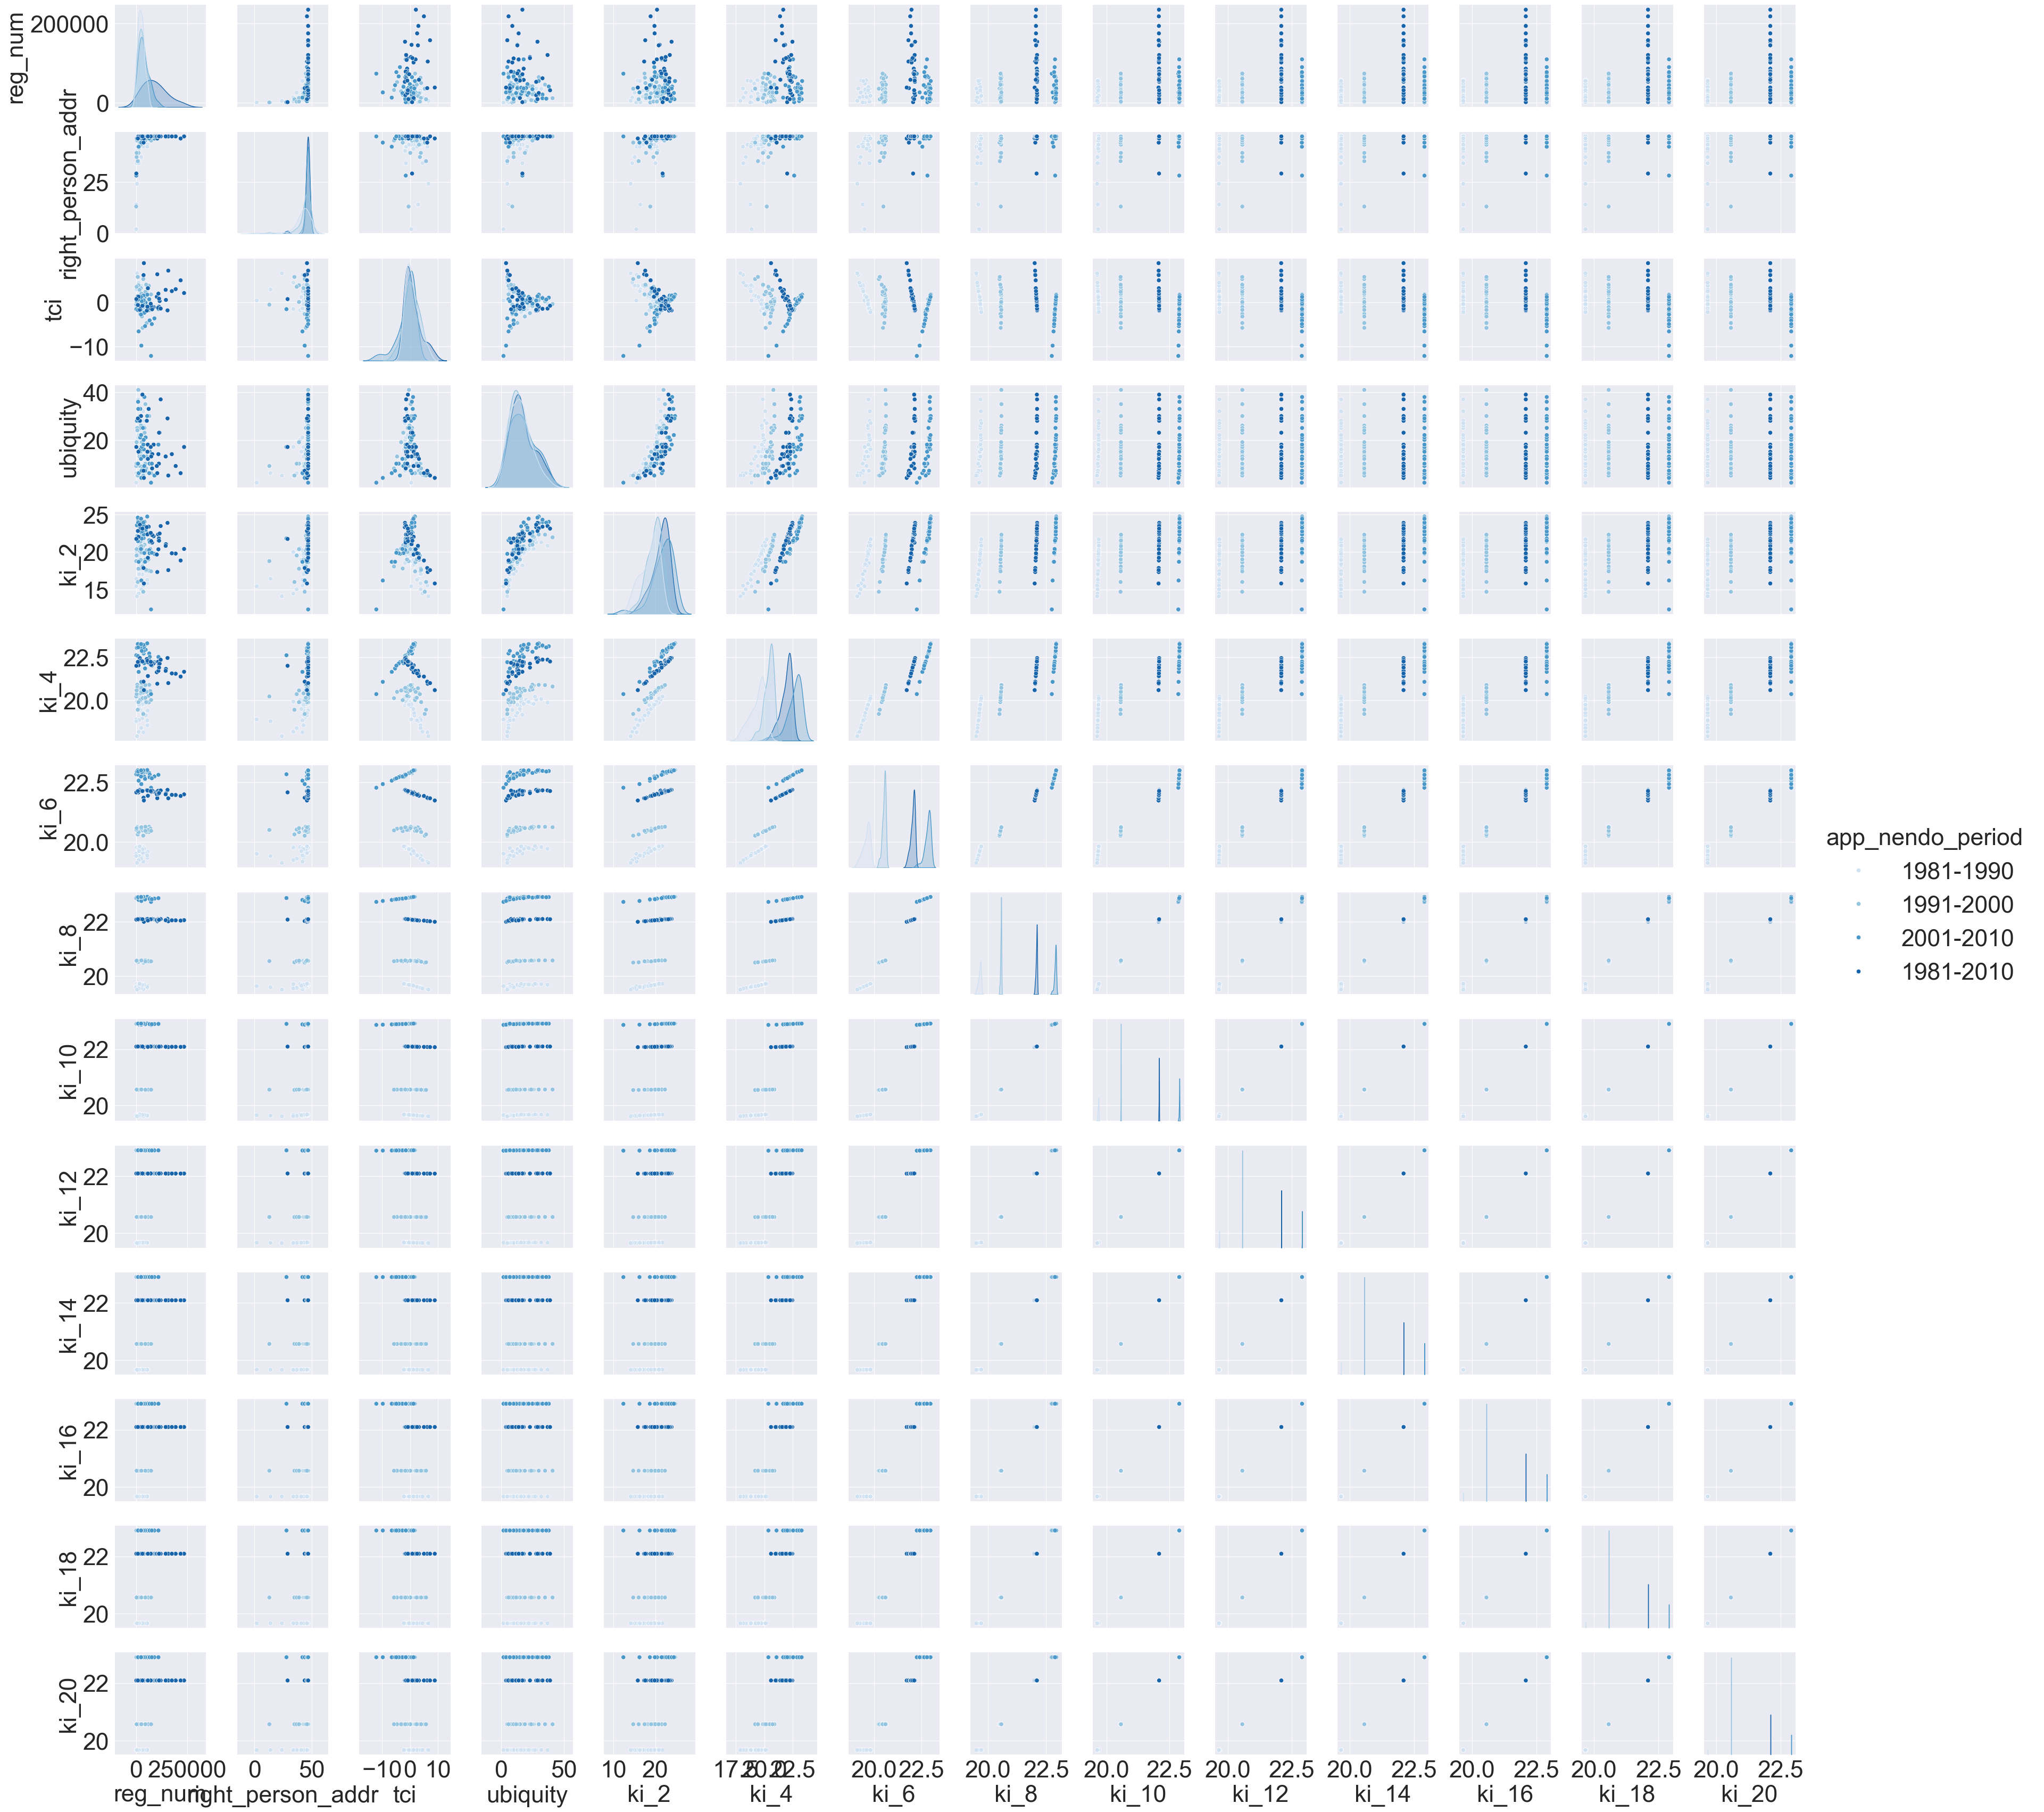

In [ ]:
# pg = sns.pairplot(
#     df[
#         [
#             f"{ar}_{year_style}_period",
#             classification,
#             "reg_num",
#             region_corporation,
#             "tci",
#             "ubiquity",
#         ]
#         + [f"ki_{i}" for i in range(2, 20 + 1, 2)]
#     ],

#     hue=f"{ar}_{year_style}_period",
#     palette="Blues",
# )
# pg

In [10]:
df[
    df[classification].isin(
        [
            "Analysis of biological materials",

            "Organic fine chemistry",

            "Biotechnology",

            "Pharmaceuticals",

            "Macromolecular chemistry, polymers",

            "Food chemistry",

            "Basic materials chemistry",

            "Materials, metallurgy",

            "Surface technology, coating",

            "Chemical engineering",

            "Other special machines",
        ]
    )
    & (df[f"{ar}_{year_style}_period"] == "1981-2010")
]

app_nendo_period    reg_num  right_person_addr  ubiquity    tci   ki_1  \
81         1981-2010  78793.833                 47        14 -1.060 13.929   
77         1981-2010 107262.333                 47        14 -1.210 14.714   
89         1981-2010  61078.500                 47        33 -1.426 13.485   
73         1981-2010  57241.167                 47        15 -1.415 14.067   
65         1981-2010  77996.833                 47         8 -1.537 15.375   
61         1981-2010  18263.500                 47        28 -1.654 13.464   
57         1981-2010  23786.000                 47        30 -0.933 13.833   
53         1981-2010  55168.333                 47        15 -0.947 14.067   
41         1981-2010   8401.500                 46        29 -0.575 13.690   
113        1981-2010 119763.667                 47        37 -1.379 12.892   
69         1981-2010  30706.000                 47        39 -0.742 12.718   

      ki_2   ki_3   ki_4   ki_5  ...  ki_12  ki_13  ki_14  ki_15  ki_16  \
81  22.265 13.576 22.217 13.479  ... 22.094 13.458 22.093 13.458 22.093   
77  22.353 13.572 22.242 13.471  ... 22.094 13.458 22.093 13.458 22.093   
89  23.381 13.470 22.365 13.462  ... 22.094 13.458 22.093 13.458 22.093   
73  22.338 13.587 22.320 13.485  ... 22.094 13.459 22.093 13.458 22.093   
65  21.261 13.669 22.179 13.488  ... 22.094 13.459 22.093 13.458 22.093   
61  23.646 13.467 22.453 13.462  ... 22.094 13.458 22.093 13.458 22.093   
57  23.156 13.504 22.320 13.468  ... 22.094 13.459 22.093 13.458 22.093   
53  22.362 13.562 22.294 13.481  ... 22.094 13.459 22.093 13.458 22.093   
41  22.811 13.507 22.231 13.468  ... 22.093 13.458 22.093 13.458 22.093   
113 23.470 13.422 22.358 13.455  ... 22.094 13.458 22.093 13.458 22.093   
69  23.130 13.398 22.258 13.451  ... 22.093 13.458 22.093 13.458 22.093   

     ki_17  ki_18  ki_19  ki_20                           schmoch35  
81  13.458 22.093 13.458 22.093         Surface technology, coating  
77  13.458 22.093 13.458 22.093               Materials, metallurgy  
89  13.458 22.093 13.458 22.093                Chemical engineering  
73  13.458 22.093 13.458 22.093           Basic materials chemistry  
65  13.458 22.093 13.458 22.093  Macromolecular chemistry, polymers  
61  13.458 22.093 13.458 22.093                     Pharmaceuticals  
57  13.458 22.093 13.458 22.093                       Biotechnology  
53  13.458 22.093 13.458 22.093              Organic fine chemistry  
41  13.458 22.093 13.458 22.093    Analysis of biological materials  
113 13.458 22.093 13.458 22.093              Other special machines  
69  13.458 22.093 13.458 22.093                      Food chemistry  

[11 rows x 26 columns]

1981-2010 -0.296


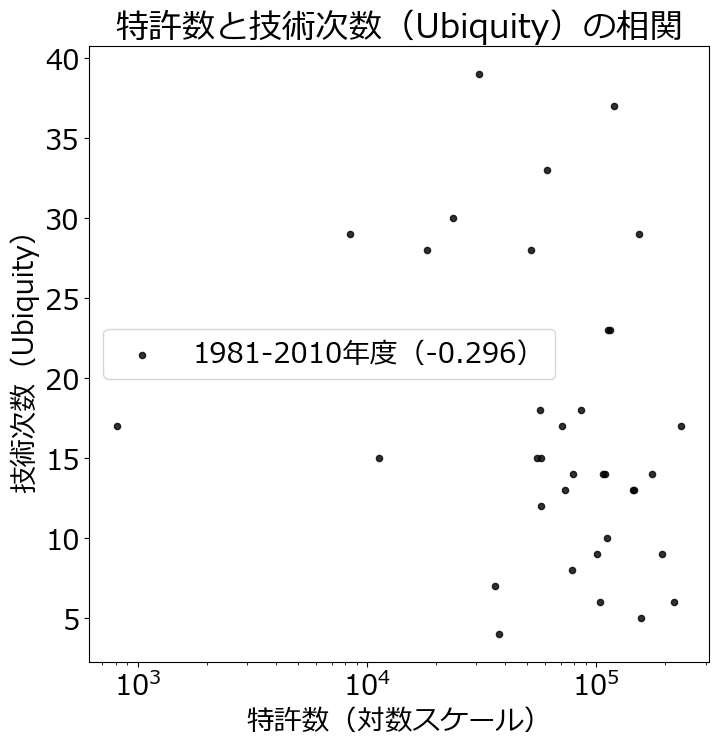

1981-2010 0.268


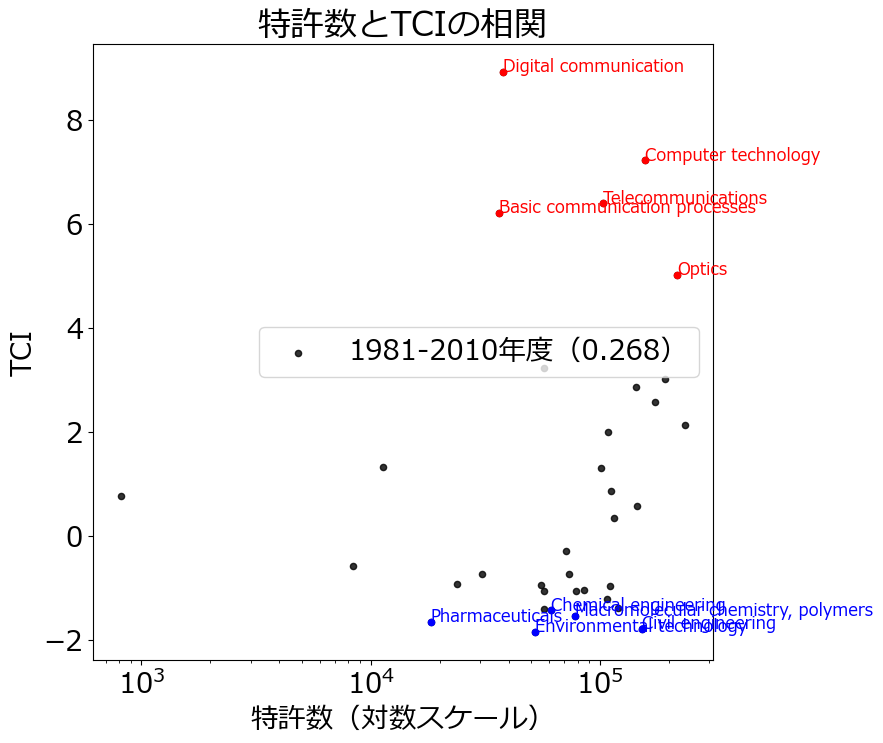

1981-2010 -0.645


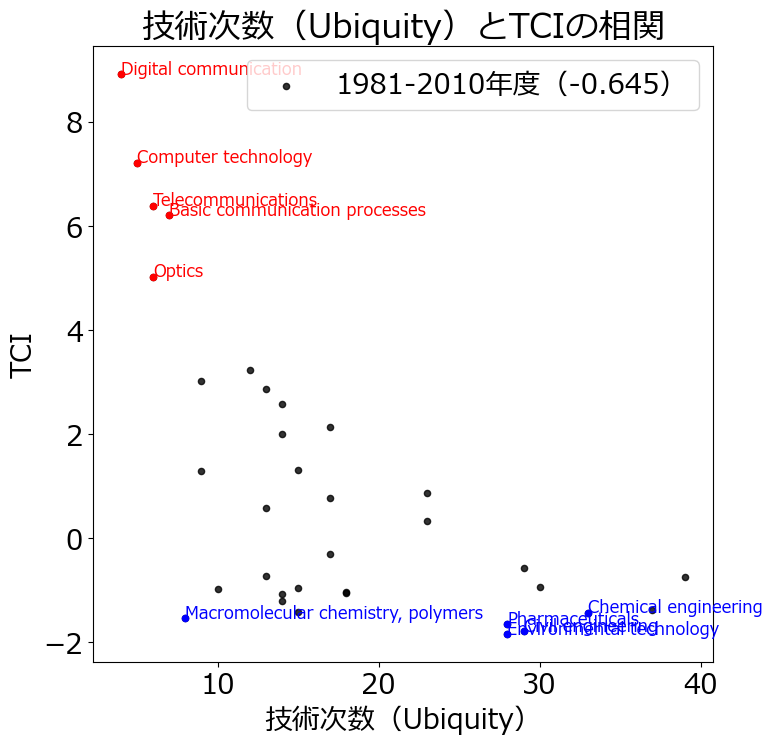

1981-2010 -0.316


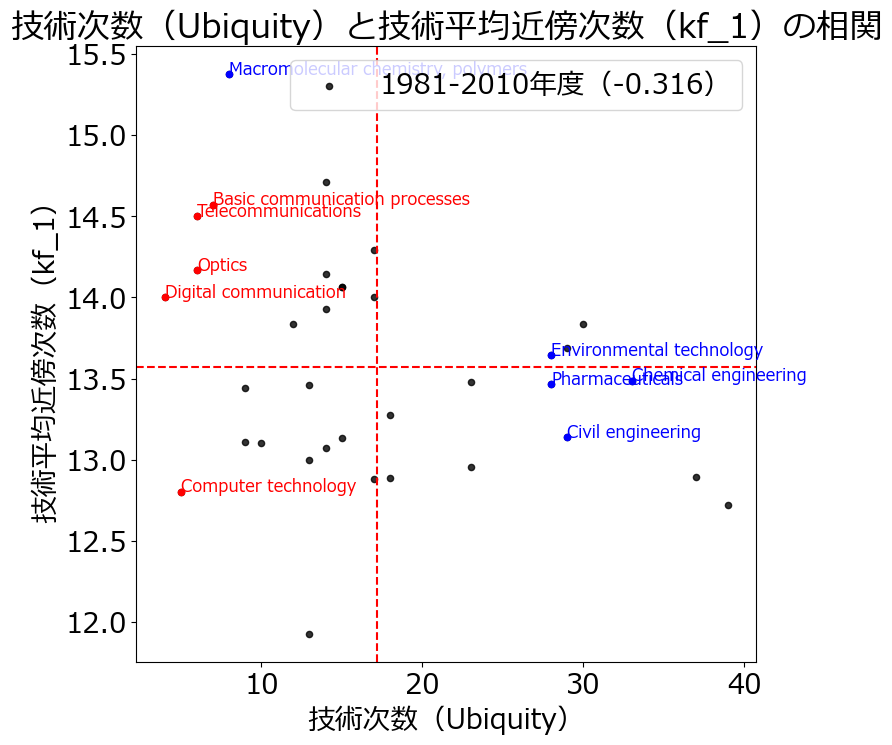

1981-2010 -0.094


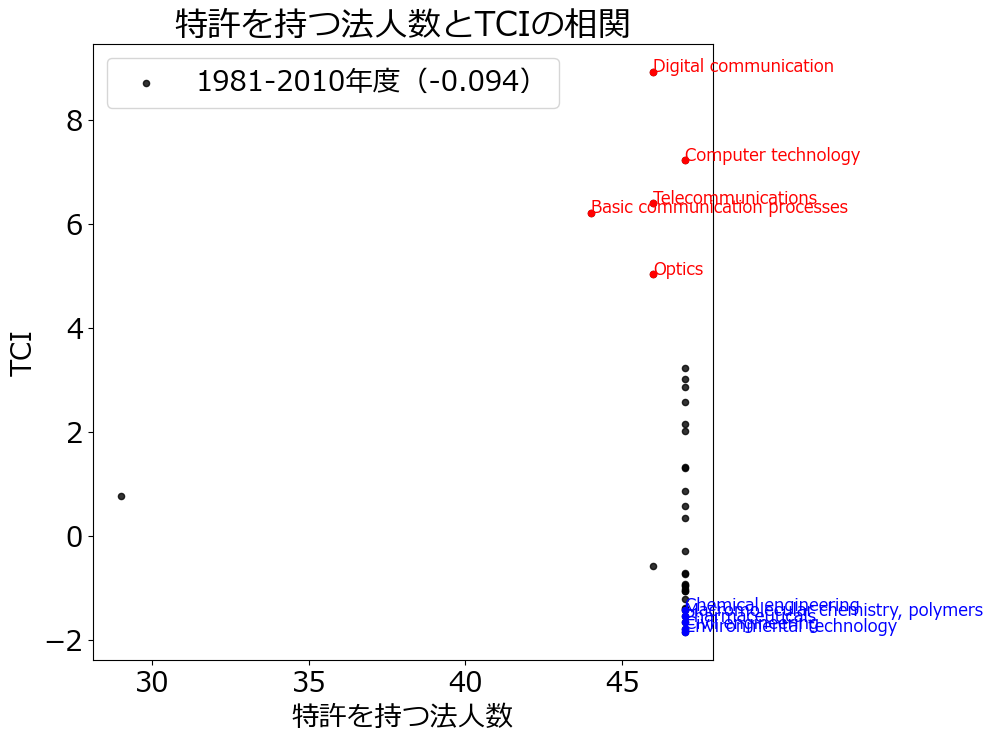

In [11]:
df_dict = {}
combi_dict = {  # ind: [x, y, title, xlabel, ylabel, legend_loc]
    1: ["reg_num", "ubiquity", "特許数と技術次数（Ubiquity）の相関", "特許数（対数スケール）", "技術次数（Ubiquity）", "best", ],
    2: ["reg_num", "tci", "特許数とTCIの相関", "特許数（対数スケール）", "TCI", "best", ],
    3: ["ubiquity", "tci", "技術次数（Ubiquity）とTCIの相関", "技術次数（Ubiquity）", "TCI", "best", ],
    4: ["ubiquity", "ki_1", "技術次数（Ubiquity）と技術平均近傍次数（kf_1）の相関", "技術次数（Ubiquity）", "技術平均近傍次数（kf_1）", "best", ],
    5: [region_corporation, "tci", "特許を持つ法人数とTCIの相関", "特許を持つ法人数", "TCI", "best",  ],
}

for i, combi in combi_dict.items():
    fig, ax = plt.subplots(figsize=(8, 8))
    period = f"{year_start}-{year_end}"
    corr_num = round(df[df[f"{ar}_{year_style}_period"] == period][combi[0]].corr(df[df[f"{ar}_{year_style}_period"] == period][combi[1]]), 3)
    print(period, corr_num)
    ax.scatter(df[df[f"{ar}_{year_style}_period"] == period][combi[0]], df[df[f"{ar}_{year_style}_period"] == period][combi[1]],
               s=20, alpha=0.8, label=f"{period}年度（{corr_num}）", color="black", )
    if i == 4:
        ax.axvline(x=df[df[f"{ar}_{year_style}_period"] == period][combi[0]].mean(), color="red", linestyle="--", )
        ax.axhline(y=df[df[f"{ar}_{year_style}_period"] == period][combi[1]].mean(), color="red", linestyle="--", )
    ax.set_title(combi[2])
    if combi[0] in ["reg_num"]: ax.set_xscale("log")
    if combi[1] in ["reg_num"]: ax.set_yscale("log")
    x_min = df[(df[f"{ar}_{year_style}_period"] == period)][combi[0]].min()
    x_2smallest = (df[(df[f"{ar}_{year_style}_period"] == period)][combi[0]].nsmallest(2).iloc[1])
    y_2smallest = (df[(df[f"{ar}_{year_style}_period"] == period)][combi[1]].nsmallest(2).iloc[1])
    if i in [2, 3, 4, 5]:
        head_df = (df[(df[f"{ar}_{year_style}_period"] == period)].sort_values("tci", ascending=False).reset_index(drop=True).head(5))
        tail_df = (df[(df[f"{ar}_{year_style}_period"] == period)].sort_values("tci", ascending=False).reset_index(drop=True).tail(5))
        for i, row in head_df.iterrows():
            ax.text(row[combi[0]], row[combi[1]], row[classification], fontsize=12, color="red")
            ax.scatter(row[combi[0]], row[combi[1]], s=20, color="red")
            
        for i, row in tail_df.iterrows():
            ax.text(row[combi[0]], row[combi[1]], row[classification], fontsize=12, color="blue", )
            ax.scatter(row[combi[0]], row[combi[1]], s=20, color="blue")
    ax.set_ylabel(combi[4])
    ax.set_xlabel(combi[3])
    ax.legend(loc=combi[5], fontsize=20)
    plt.show()


In [12]:
# fig, ax = plt.subplots(figsize=(20, 40), squeeze=False, sharey=False)
def plot_to_image(f):
    buf = io.BytesIO()
    f.savefig(buf, format="png", bbox_inches="tight")
    plt.close()
    buf.seek(0)
    img = Image.open(buf)
    return img


color_count = 0
img_list = []
for period in range(year_start, year_end + 1, year_range):

    fig, ax = plt.subplots(figsize=(3, 30))
    period = f"{period}-{period+year_range-1}"
    plot_df = (
        df[df[f"{ar}_{year_style}_period"] == period]
        .groupby([classification])[["reg_num"]]
        .sum()
        .sort_values("reg_num", ascending=True)
    )
    ax.barh(
        list(plot_df.index),
        list(plot_df["reg_num"].values),
        color=color_list[color_count],
        label=period,
    )
    ax.set_yticklabels(plot_df.index, fontsize=15)
    ax.set_xticklabels(
        [x for x in range(0, 80000 + 1, 20000)], fontsize=20, rotation=90
    )
    ax.set_xlim(0, 90000)
    # ax.set_xticklabels(fontsize=15, rotation=90)
    xax2 = ax.secondary_xaxis("top")
    # xax2.xaxis.set_major_formatter(ptick.FuncFormatter(lambda x, _: f'{int(x):,}'))
    xax2.set_xticklabels([int(i) for i in ax.get_xticks()], fontsize=20, rotation=90)
    xax2.set_xlim(ax.get_xlim())
    ax.legend(fontsize=20, loc="upper center")
    ax.set_axisbelow(True)
    ax.grid(which="major", axis="x", linestyle="--")
    c_i = 0
    for c in plot_df.index:
        reg_num = plot_df[plot_df.index == c]["reg_num"].values[0]
        ax.text(x=40000, y=c_i, s=round(reg_num, 1), fontsize=20, color="black")
        #     ax.set_xticklabels(df[df[f'{ar}_{year_style}_period'] == period].groupby([classification])['reg_num'].sum().index, rotation=90, fontsize=15)
        c_i += 1
    color_count += 1
    img_list.append(plot_to_image(fig))

    # fig.savefig(f'{output_dir}{ar}_{year_style}_{classification}_{period}.png', bbox_inches='tight')
combined_img = Image.new(
    "RGB", (sum([img.width for img in img_list]), img_list[0].height)
)
w, h = 0, 0
for img_i, img in enumerate(img_list):
    combined_img.paste(img, (w, h))
    w += img.width
combined_img.save(f"{output_dir}tech_reg_num/{fig_name_base}", "PNG")
# combined_img.show()
plt.show()

C:\Users\rin\AppData\Local\Temp\ipykernel_18712\4080642559.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(plot_df.index, fontsize=15)
C:\Users\rin\AppData\Local\Temp\ipykernel_18712\4080642559.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(
C:\Users\rin\AppData\Local\Temp\ipykernel_18712\4080642559.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  xax2.set_xticklabels([int(i) for i in ax.get_xticks()], fontsize=20, rotation=90)
C:\Users\rin\AppData\Local\Temp\ipykernel_18712\4080642559.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(plot_df.index, fontsize=15)
C:\Users\rin\AppData\Local\Temp\ipykernel_18712\4080642559.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(
C:\Users\rin\AppData\Local\Temp\ipykernel_18712\4080642559.py:37: Use

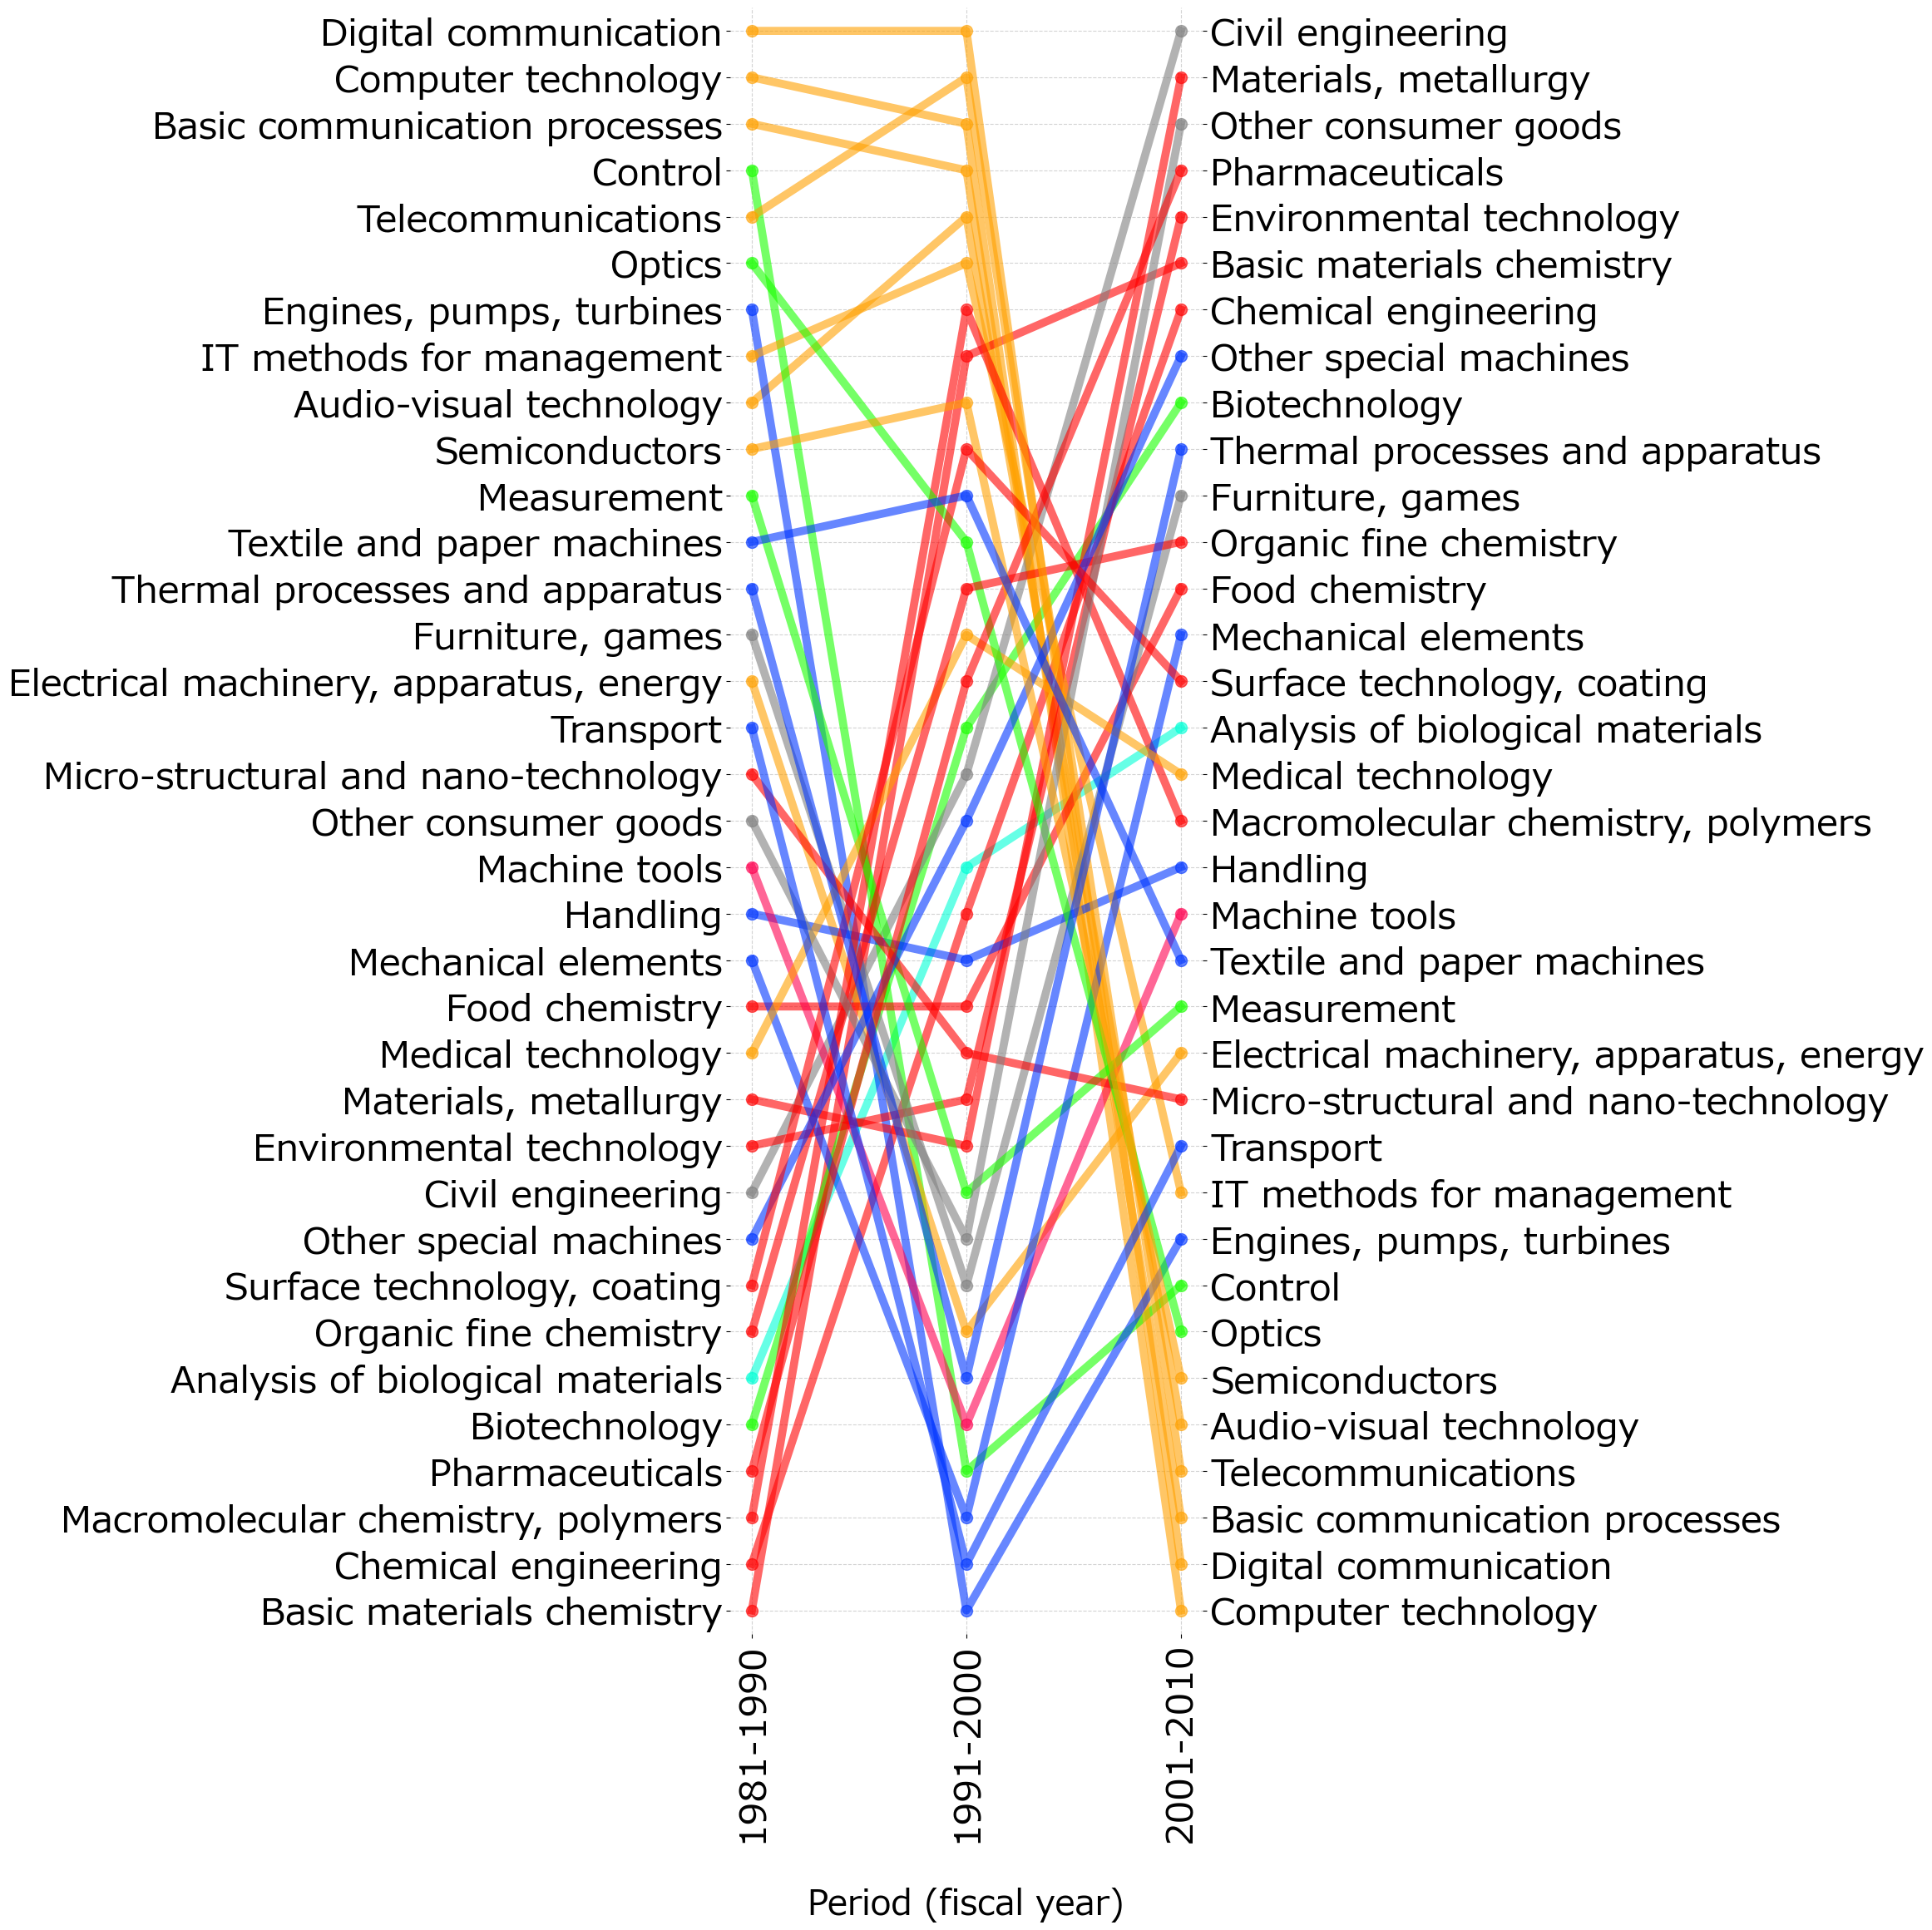

In [13]:
df_dict = {}
combi_dict = {
    #   5: [classification, 'ubiquity', f'IPC次数(=ubiquity, k_i0)ランキング 低次数Top15の推移（出願期間：{year_start}-{year_end}年度）', True],
    #   5: [classification, 'ubiquity', f'', True],
    #   6: ['ipc_class', 'ubiquity', f'IPC次数(=ubiquity, k_i0)ランキング 高次数Top15の推移（出願期間：{year_start}-{year_end}年度）', False],
    #   7: ['ipc_class', 'pci', f'TCI(Technological Compexity Index)ランキング 値が低いものTop15の推移（出願期間：{year_start}-{year_end}年度）', True],
    #   8: [classification, 'tci', f'TCI(Technological Compexity Index)ランキング 値が高いものTop15の推移（出願期間：{year_start}-{year_end}年度）', False]
    8: [classification, "tci", "", False]
}


for i, combi in combi_dict.items():
    div_df = (
        df[[f"{ar}_{year_style}_period"] + combi[: 1 + 1]]
        .sort_values(
            by=[f"{ar}_{year_style}_period", combi[1]], ascending=[True, False]
        )
        .copy()
    )
    div_df = div_df.drop_duplicates(keep="first")
    div_df_dict = {}
    for year in range(year_start, year_end + 1, year_range):
        period = f"{year}-{year+year_range-1}"
        div_df_dict[period] = div_df[
            div_df[f"{ar}_{year_style}_period"] == period
        ].copy()
        # display(div_df_dict[f'{year}-{year+year_range-1}'].head(15))
    if i == 4:
        df["kci_rank"] = (
            df.groupby(f"{ar}_{year_style}_period")[["kci"]]
            .rank(ascending=False, method="first")
            .reset_index(drop=False)["kci"]
        )
        # display(c_df[c_df['right_person_name'].str.contains('三菱重工業')])
    if i > 4:
        fs = (24, 24)
    else:
        fs = (10, 12)
    # display(div_df)
    sample = vr.rank_doubleaxis(
        div_df_dict,
        rank_num=35,
        member_col=combi[0],
        value_col=combi[1],
        prop_dict={
            "figsize": fs,
            "xlabel": "期間",
            "ylabel": "",
            "title": combi[2],
            "fontsize": 32,
            "year_range": year_range,
            "ascending": combi[3],
            # 'color': color_dict
            "color": "default",
        },
    )
    # plt.tight_layout()
    plt.xlabel("\nPeriod (fiscal year)", fontsize=30)
    plt.savefig(
        f"{output_dir}{combi[1]}_{fig_name_base}",
        bbox_inches="tight",
    )
    plt.show()

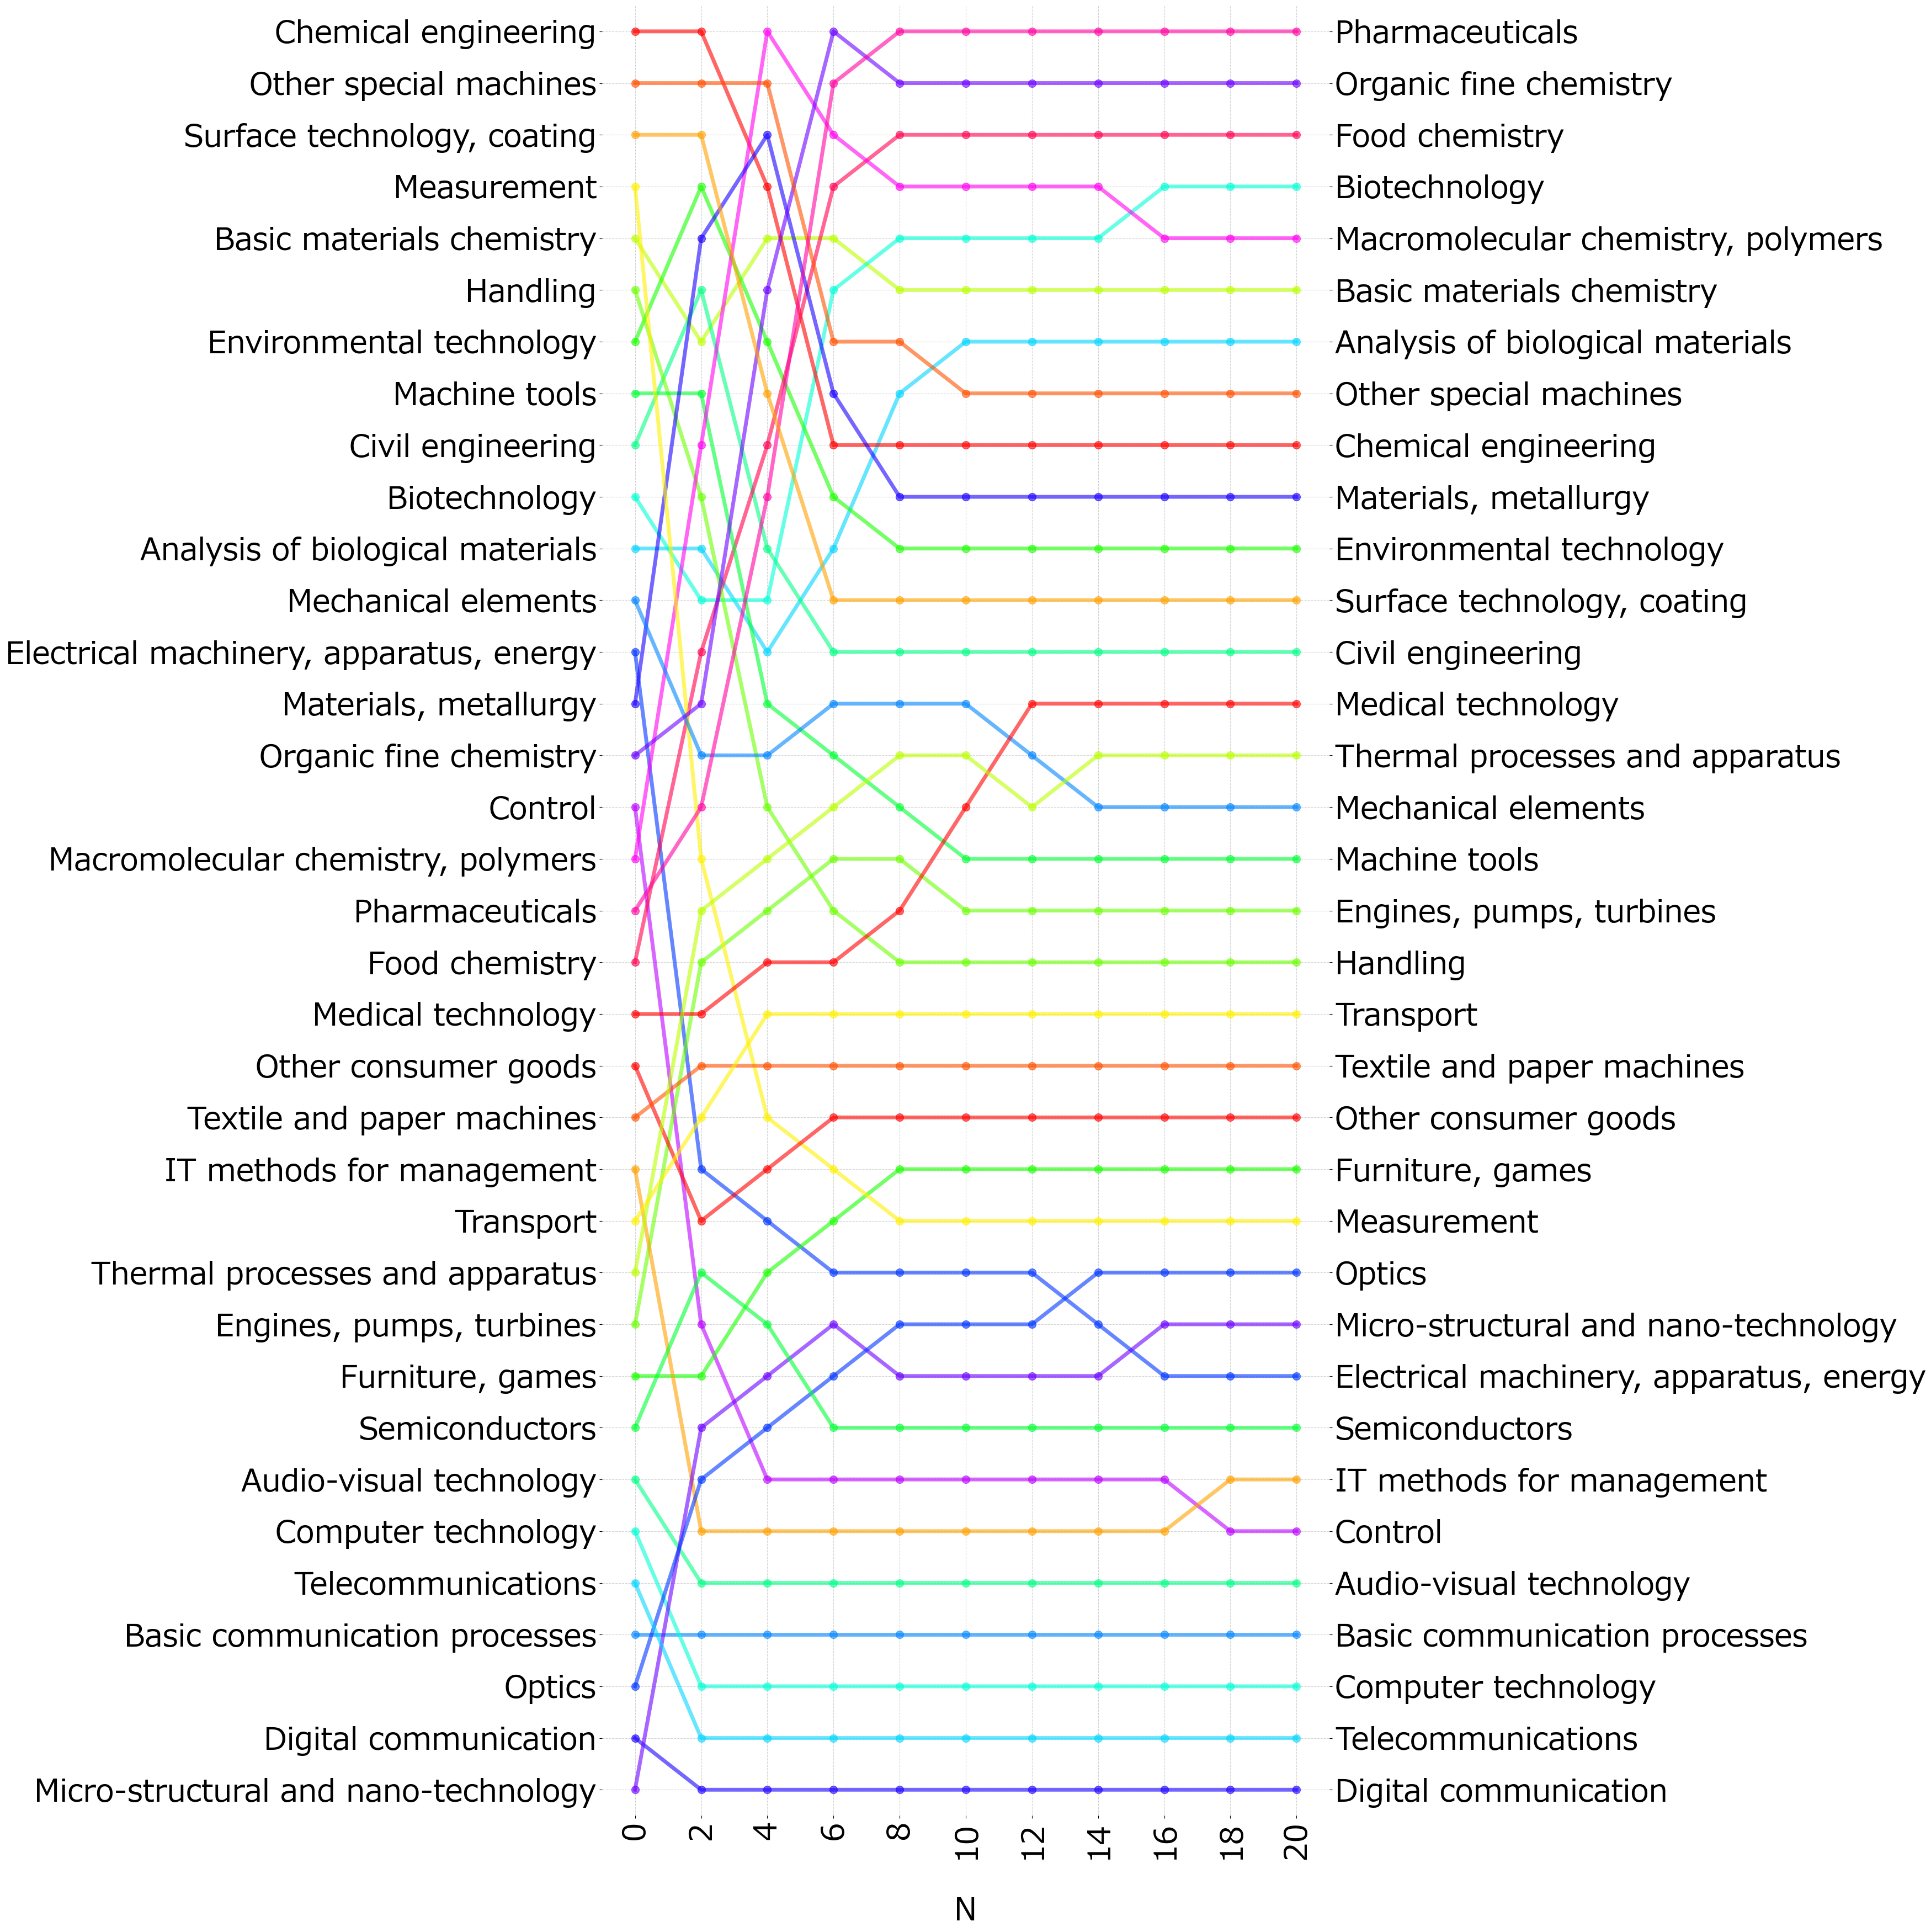

In [ ]:
sample_df = (
    df[(df[f"{ar}_{year_style}_period"] == f"{year_start}-{year_end}")]
    .sort_values("tci", ascending=False)
    .copy()

)
sample_df_dict = {
    "0": sample_df.melt(id_vars=[classification], value_vars=["ubiquity"]).sort_values(
        "value", ascending=False
    )
}

fs = (36, 36)

for i in range(2, 20 + 1, 2):

    sample_df_dict[f"{i}"] = sample_df.melt(
        id_vars=[classification], value_vars=[f"ki_{i}"]
    ).sort_values("value", ascending=False)

    # if i >= 12: display(sample_df_dict[f'{i}'].head(10))

sample = vr.rank_doubleaxis(
    sample_df_dict,

    version="kci",

    rank_num=35,

    member_col=classification,
    num_col="value",

    prop_dict={

        "figsize": fs,

        "xlabel": "N",

        "ylabel": "",
        "title": "",

        "fontsize": 40,

        "year_range": 2,
        "ascending": False,
        # 'color': color_dict
        "color": "default",

    },
)